In [67]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hammaadali_arial_font_path = kagglehub.dataset_download('hammaadali/arial-font')
yassinabdulmahdi_arabic_medical_q_and_a_dataset_path = kagglehub.dataset_download('yassinabdulmahdi/arabic-medical-q-and-a-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install wordcloud
!pip install tashaphyne
!pip install qalsadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 21.5 MB/s eta 0:00:00
  Created wheel for pickledb: filename=pickleDB-1.3.2-py3-none-any.whl size=5289 sha256=d757ba59a41bbdc717d749709bb6d4

In [3]:
import numpy as np # linear algebra
import pandas as pd
import re
import string
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
import qalsadi.lemmatizer as ql
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
lemmatizer = ql.Lemmatizer()
import pyarabic.araby as araby
stop_words = stopwords.words('arabic')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Exportation

In [8]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
val=pd.read_csv('/content/val.csv')

In [ ]:
train.shape

(52758, 3)

In [ ]:
test.shape

(17586, 3)

In [ ]:
val.shape

(17586, 3)

# Data Cleaning

## Exploring missing values:

In [9]:
print(f'Missing values for train: {train.isnull().sum()}')
print(f'Missing values for test: {test.isnull().sum()}')
print(f'Missing values for val: {val.isnull().sum()}')

Missing values for train: question      0
answer      101
label         0
dtype: int64
Missing values for test: question     0
answer      34
label        0
dtype: int64
Missing values for val: question     0
answer      39
label        0
dtype: int64


We can see that we have missing values for the 'answer' column in all train, test and val data; we have no other options but to drop them.

In [10]:
qsts_without_answers_train=train[train['answer'].isnull()]
qsts_without_answers_test=test[test['answer'].isnull()]
qsts_without_answers_val=val[val['answer'].isnull()]

In [11]:
train.drop(qsts_without_answers_train.index,inplace=True)
test.drop(qsts_without_answers_test.index,inplace=True)
val.drop(qsts_without_answers_val.index,inplace=True)

In [12]:
print(f'Missing values for train: {train.isnull().sum()}')
print(f'Missing values for test: {test.isnull().sum()}')
print(f'Missing values for val: {val.isnull().sum()}')

Missing values for train: question    0
answer      0
label       0
dtype: int64
Missing values for test: question    0
answer      0
label       0
dtype: int64
Missing values for val: question    0
answer      0
label       0
dtype: int64


## Normalizing the columns:
For the column 'label', there are many labels that refers to the same categorie: such as  (أمراض الدم,أمراض_الدم,امراض الدم,امراض_الدم) so we need to normalize this column.

In [13]:
train['label'].value_counts()

,count
label,
الاورام-الخبيثة-والحميدة,9523
جراحة-عامة,9424
امراض-الغدد-الصماء,6714
مرض-السكري,5604
امراض-الجهاز-التنفسي,4471
ارتفاع-ضغط-الدم,3888
جراحة-العظام,2497
امراض-الدم,1711
الغدد-الصماء,1068


In [14]:
def normalize_label_column(dataset):
    dataset['label']=dataset['label'].str.replace('_', ' ')
    dataset['label']=dataset['label'].str.replace('-', ' ')
    dataset['label']=dataset['label'].str.replace('أ', 'ا')
    dataset['label']=dataset['label'].str.strip()
    dataset['label'] = dataset['label'].str.replace(r'\s+', ' ', regex=True)


    '''dataset['label'] = dataset['label'].replace({
        'امراض الدم': 'الدم',
        'مرض السكري': 'السكري',
        'امراض الجهاز التنفسي': 'الجهاز التنفسي'
    })'''

In [15]:
qst1=train['question'].iloc[1] #type of qst1 est str
ans1=train['answer'].iloc[1]
print(f"Question:{qst1}")
print(f"Answer:{ans1}")

Question:
اليك نتيجة تحليل هرمونات الغدة الدرقية علما بانه تم استأصال الغدة منذ اكثر من سنتينTT3=163TT4=12.6TSH=.01 هل مطلوب تعديل الجرعة 
Answer:

نعم. يجب تخفيض الجرعة، الا اذا كان سبب استئصال الغدة هو سرطان الغدة
0
2017-02-13 06:34:19


الدكتور باسم مرقص







/اسئلة-طبية/امراض-الغدد-الصماء/اليك-نتيجة-تحليل-هرمونات-الغدة-الدرقية-علما-بانه-تم-909154

الدكتور باسم مرقص 


جراحة عامة 





After examining the responses to various inquiries, it's apparent that they include timestamps of the replies, the name of the responding doctor, and their medical specialty. While informative, these details are extraneous to our analysis and can be safely removed. Additionally, we've noticed paths like '/اسئلة-طبية/امراض-الغدد-الصماء/اليك-نتيجة-تحليل-هرمونات-الغدة-الدرقية-علما-بانه-تم-909154' embedded within the data. To ensure cleanliness and relevance, these paths should also be removed.
We can do that by removing the timestamp and everything after it.

In [16]:
def clean_text(text):
    text = re.sub(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.*$', '', text)
    text = re.sub(r'\d$', '', text)#To remove the number that exists at the end of each answer
    return text

def clean_question_and_answer_columns(dataset):
    dataset['question']=dataset['question'].str.strip()
    dataset['answer']=dataset['answer'].str.strip()
    dataset['question']=dataset['question'].str.replace('\n',' ')
    dataset['answer']=dataset['answer'].str.replace('\n',' ')
    dataset['answer'] = dataset['answer'].apply(clean_text)

In [17]:
normalize_label_column(train)
normalize_label_column(test)
normalize_label_column(val)
train['label'].value_counts()

,count
label,
الاورام الخبيثة والحميدة,10697
جراحة عامة,10531
امراض الغدد الصماء,8336
مرض السكري,6147
امراض الجهاز التنفسي,5301
ارتفاع ضغط الدم,4170
جراحة العظام,2639
امراض الدم,1930
الغدد الصماء,1068


In [18]:
clean_question_and_answer_columns(train)
clean_question_and_answer_columns(test)
clean_question_and_answer_columns(val)

In [20]:
qst1=train['question'].iloc[1] #type of qst1 est str
ans1=train['answer'].iloc[1]
print(f"Question:{qst1}")
print(f"Answer:{ans1}")

Question:اليك نتيجة تحليل هرمونات الغدة الدرقية علما بانه تم استأصال الغدة منذ اكثر من سنتينTT3=163TT4=12.6TSH=.01 هل مطلوب تعديل الجرعة
Answer:نعم. يجب تخفيض الجرعة، الا اذا كان سبب استئصال الغدة هو سرطان الغدة 0 


In [21]:
train

,question,answer,label
0,ما هي مميزات و عيوب الدواء جلوكوفانس 500 5 و ا...,لكل علاج ايجابيته وسلبياته والتي تعتمد على حال...,الدم
1,اليك نتيجة تحليل هرمونات الغدة الدرقية علما با...,نعم. يجب تخفيض الجرعة، الا اذا كان سبب استئصال...,الاورام الخبيثة والحميدة
2,حلول منزلية لأعراض ارتفاع ضغط الدم,يفضل عدم الاستغناء عن العلاج الدوائي لمرضى الض...,جراحة عامة
3,عملت عملية دوالي الساقين قسطرة الليزر من شهر و...,راجع طبيبك من اجري الجراحه افضل من يجيب لانه ش...,امراض الجهاز التنفسي
4,ما حقيقة ان تمرين العضلة النعلية يخفض السكر با...,إذا قصدت تدليك العضلة فهذا كلام غير صحيح . ولك...,مرض السكري
...,...,...,...
52753,السلام عليكم . يوجد لسع والم وتحجر وورم فى ثما...,راجع جراحك ولا خوف 0,جراحة عامة
52754,هل يمكن ان يرتفع السكر الى 570 دون اعراض مع ال...,ليس بالضرورة وجود اعراض ويجب المتابعة عن طريق ...,مرض السكري
52755,هل يمكن علاج سرطان الثدى المرحله الثانيه فى اح...,طبعاً هناك بروتوكول يجب إتباعه. ولكنه بالنهاية...,الاورام الخبيثة والحميدة
52756,اعاني من دوخه ونسبه السكر من 69 الى 80 بشكل دا...,"سلامتك ان شاء الله , قد يكون طبيعي بنقص كميات ...",مرض السكري


In [22]:
if test.shape == val.shape:
    # Check if all elements are identical row-wise
    are_identical = (test.values == val.values).all()
    if are_identical:
        print("Test and Val datasets are identical.")
    else:
        print("Test and Val datasets are not identical.")
else:
    print("Test and Val datasets have different shapes.")

Test and Val datasets have different shapes.


# EDA:

In [23]:
label_counts=train['label'].value_counts()
label_counts

,count
label,
الاورام الخبيثة والحميدة,10697
جراحة عامة,10531
امراض الغدد الصماء,8336
مرض السكري,6147
امراض الجهاز التنفسي,5301
ارتفاع ضغط الدم,4170
جراحة العظام,2639
امراض الدم,1930
الغدد الصماء,1068


In [24]:
label_counts_df=label_counts.to_frame()
label_counts_df['% of each label']=label_counts_df['count']/len(train)
label_counts_df['% of each label']

,% of each label
label,
الاورام الخبيثة والحميدة,0.203145
جراحة عامة,0.199992
امراض الغدد الصماء,0.158308
مرض السكري,0.116737
امراض الجهاز التنفسي,0.100670
ارتفاع ضغط الدم,0.079192
جراحة العظام,0.050117
امراض الدم,0.036652
الغدد الصماء,0.020282


Having these values, we can conclude:
* Malignant and benign tumors (الاورام الخبيثة والحميدة) stand out as the most frequently inquired category, comprising approximately 20% of all questions received.
* General surgery (جراحة عامة) closely follows as another highly queried category, constituting nearly 20% of the total questions.
* Endocrine disorders (امراض الغدد الصماء) rank prominently among the queried categories, representing about 16% of the overall inquiries.
* Diabetes mellitus (مرض السكري) emerges as a significant concern, with around 12% of the questions directed towards this category.
* Respiratory system (امراض الجهاز التنفسي) diseases garner notable attention, accounting for approximately 10% of the inquiries received.
* Hypertension (ارتفاع ضغط الدم ) holds a substantial portion of the queries, making up about 8% of the total questions.
* As for other matters such as Orthopedic surgery (جراحة العظام), Blood disorders (امراض الدم)... their frequencies are comparatively lower, suggesting they are of lesser concern or interest among the inquiries.

**We can conclude that the chatbot that we will create after will respond better to questions regarding issues with high frequency such as Malignant and benign tumors (الاورام الخبيثة والحميدة) as well as General surgery (جراحة عامة). These categories are likely to receive more inquiries and thus require more comprehensive and accurate responses from the chatbot.**

In [25]:
# for test and val dataframes:
label_counts_test=test['label'].value_counts()
label_counts_df_test=label_counts.to_frame()
label_counts_df_test['% of each label']=label_counts_df_test['count']/len(test)
label_counts_df_test['% of each label']

,% of each label
label,
الاورام الخبيثة والحميدة,0.609446
جراحة عامة,0.599989
امراض الغدد الصماء,0.474932
مرض السكري,0.350216
امراض الجهاز التنفسي,0.302017
ارتفاع ضغط الدم,0.237580
جراحة العظام,0.150353
امراض الدم,0.109959
الغدد الصماء,0.060848


In [26]:
label_counts_val=val['label'].value_counts()
label_counts_df_val=label_counts.to_frame()
label_counts_df_val['% of each label']=label_counts_df_val['count']/len(val)
label_counts_df_val['% of each label']

,% of each label
label,
الاورام الخبيثة والحميدة,0.609620
جراحة عامة,0.600160
امراض الغدد الصماء,0.475067
مرض السكري,0.350316
امراض الجهاز التنفسي,0.302103
ارتفاع ضغط الدم,0.237647
جراحة العظام,0.150396
امراض الدم,0.109990
الغدد الصماء,0.060865


**The categories more frequently encountered in the training data are also more commonly seen in the testing and validation datasets**

## WordCloud:

In [ ]:
len(stop_words)

754

In [27]:
stopwords = [arabic_reshaper.reshape(s) for s in stop_words]

In [28]:
def column_to_wordcloud(df, column, font_file, stopwords):
    text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())
    # create and display the wordcloud
    wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,
                      stopwords = stopwords).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Data Preprocessing:

In [29]:
stop_words=set(stop_words)
#stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}
#print(stop_word_comp.issubset(stop_words) )

In [ ]:
#stopwords=stopwords.union(stop_word_comp)

In [30]:
qst1=train['question'].iloc[1] #type of qst1 est str
ans1=train['answer'].iloc[1]
print(f"Question:{qst1}")
print(f"Answer:{ans1}")

Question:اليك نتيجة تحليل هرمونات الغدة الدرقية علما بانه تم استأصال الغدة منذ اكثر من سنتينTT3=163TT4=12.6TSH=.01 هل مطلوب تعديل الجرعة
Answer:نعم. يجب تخفيض الجرعة، الا اذا كان سبب استئصال الغدة هو سرطان الغدة 0 


In [31]:
class ArabicTextPreprocessor:
    def __init__(self):
        pass

    def remove_punctuation(self,text):
        punc=string.punctuation+"،"
        text= text.translate(str.maketrans('', '', punc))
        return text
    def adding_a_space_between_a_word_and_a_punctuation(self,text):
        text = re.sub(r"([?.!,¿،])", r" \1 ", text)
        text = re.sub(r'[" "]+', " ", text)
        return text
    def remove_stopwords(self,text,stopwords):
        textb=TextBlob(text)
        words=textb.words
        return " ".join([w for w in words if w not in stop_words])
    def lemmatize(self,text):
        lemmas= [lemmatizer.lemmatize(word) for word in text.split()]
        return " ".join(lemmas)
    def normalizeArabic(self,text):
        text = text.strip()
        text = re.sub("[إأٱآا]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ؤ", "ء", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("ة", "ه", text)
        noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
        text = re.sub(noise, '', text)
        text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
        return araby.strip_tashkeel(text)

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    def add_start_and_end_tokens(self,text):
        return '<end> '+text.strip()+' <start>'


In [32]:
#Preprocessing train, test and val data:
def Preprocess_data(dataset,column_name):
    p=ArabicTextPreprocessor()
    dataset[column_name]=dataset[column_name].apply(p.adding_a_space_between_a_word_and_a_punctuation)
    dataset[column_name]=dataset[column_name].apply(p.normalizeArabic)
    dataset[column_name]=dataset[column_name].apply(p.add_start_and_end_tokens)

In [33]:
#train:
Preprocess_data(train,'question')
Preprocess_data(train,'answer')
#test
Preprocess_data(test,'question')
Preprocess_data(test,'answer')
#val
Preprocess_data(val,'question')
Preprocess_data(val,'answer')

In [ ]:
train.head()

,question,answer,label
0,<end> ما هي مميزات و عيوب الدواء جلوكوفانس 500...,<end> لكل علاج ايجابيته وسلبياته والتي تعتمد ع...,الدم
1,<end> اليك نتيجه تحليل هرمونات الغده الدرقيه ع...,<end> نعم . يجب تخفيض الجرعه ، الا اذا كان سبب...,الاورام الخبيثة والحميدة
2,<end> حلول منزليه لاعراض ارتفاع ضغط الدم <start>,<end> يفضل عدم الاستغناء عن العلاج الدواءي لمر...,جراحة عامة
3,<end> عملت عمليه دوالي الساقين قسطره الليزر من...,<end> راجع طبيبك من اجري الجراحه افضل من يجيب ...,امراض الجهاز التنفسي
4,<end> ما حقيقه ان تمرين العضله النعليه يخفض ال...,<end> اذا قصدت تدليك العضله فهذا كلام غير صحيح...,مرض السكري


# Try retrievel method using cosine similarity:


In [34]:
print("train:",train.isnull().sum())
print("test:",test.isnull().sum())
print("val:",val.isnull().sum())

train: question    0
answer      0
label       0
dtype: int64
test: question    0
answer      0
label       0
dtype: int64
val: question    0
answer      0
label       0
dtype: int64


In [68]:
train.fillna("", inplace=True)
vectorizer = TfidfVectorizer()

vectorizer.fit(train.values.ravel())


TfidfVectorizer()

In [72]:
# Fit the vectorizer on the dataset questions
vectorizer = TfidfVectorizer()
vectorizer.fit(train['question'])

# Transform the dataset questions
questions_transformed = vectorizer.transform(train['question'])

# Select one question randomly from the dataset
random_index = random.randint(0, len(train) - 1)
random_question = train['question'].iloc[random_index]

# Transform the selected question
question_transformed = vectorizer.transform([random_question])

# Rank all the questions using cosine similarity to the selected question
rank = cosine_similarity(question_transformed, questions_transformed)

# Grab the top 5 excluding the selected question itself
top_indices = np.argsort(rank, axis=1).flatten()[-6:-1]  # Exclude the selected question itself

print(f"Selected Question: {random_question}")
print("Top 5 similar answers:")

# Print top 5 answers
for idx in top_indices:
    print(train['answer'].iloc[idx])
    print("\n ########## \n")

Selected Question: <end> هل حبوب تنظيم السكر تساعد علي التنحيف برغم انني الحمدلله لا اعاني من اي مرض بس اريد ان انحف <start>
Top 5 similar answers:
<end> لا نحبذ العلاج بالاعشاب و ذلك لعدم وجود دراسات طبيه كافيه عليها 0 <start>

 ########## 

<end> يجب ضبط فحص الغده اولا فاذا لم ينخفض الوزن فذلك يعني ان لاعلاقه للغده بذلك 0 <start>

 ########## 

<end> من الممكن ان يساعد 1 <start>

 ########## 

<end> -تقصدين الميتفورمين مثل الجلوكوفاج او السيدوفاج - من ضمن علاج تكيس المبايض هذه الماده و عند التخلص من تكيس المبايض تنتظم الهرمونات 1 <start>

 ########## 

<end> افضل نظام للتحكم في السكري هو استخدام الانسولين القاعدي مثل اللانتوس او الليفيمير مع السريع للوجبات الاساسيه مثل نوفو رابيد او الاكت رابيد طبعا لابد من اتباع نظام غذاءي صحي و ممارسه الرياضه بشكل يومي 0 <start>

 ########## 



In [ ]:
# Similarity-Based Retrieval with User Input
def retrieve_similar_answers(query, top_k=5):
    """Retrieves top k similar answers to a user query."""
    # Transform the query using the fitted vectorizer
    query_transformed = vectorizer.transform([query])

    # Calculate cosine similarity between query and dataset questions
    rank = cosine_similarity(query_transformed, questions_transformed)

    # Get indices of top k similar questions
    top_indices = np.argsort(rank, axis=1).flatten()[-top_k:]

    # Return top k similar answers
    return train['answer'].iloc[top_indices].values

# Get user query
user_query = input('Please enter your medical query: ')

# Retrieve and print top similar answers
top_answers = retrieve_similar_answers(user_query)
print("\nTop similar answers:")
for answer in top_answers:
    print(answer)
    print("\n##########\n")

Please enter your medical query: اشعر بضيق تنفس ما السبب؟

Top similar answers:
<end> الاختناق اثناء النوم يجب توضيحه لعده اسباب : هل يوجد ربو و هل يتم الاستيقاظ من النوم . هل مصاحب بسعال او ازيز بالصدر ام هو مجرد كابوس بسبب الاكل قبل النوم الاسباب كثيره منها الربو - الارتجاع المريءي - اضطرابات النوم - مشاكل بالقلب - بعض الاسباب تتعلق بالحجاب الحاجز و ايضا بالفتق بالحجاب الحاجز لذا يجب توضيح الاعراض 1 <start>

##########

<end> بمكنك مراجعه طبيب القلب قبل كل شء 1 <start>

##########

<end> غالبا ما تكون حساسيه بالصدر تحتاج اشعه صدر و استشاره طبيب صدر 1 <start>

##########

<end> هل لديك سعال او اس اعراض اخري ؟ من الممكن ان يكون ربو او تحسس من شيء ما الافضل مراجعه طبيب صدريه و عمل وظاءف رءهللتاكد من نفي اي سبب اخر 1 <start>

##########

<end> قد يكون نتيجه عدم وجود لياقه بدنيه او ممارسه الرياضه بصوره خاطءه و لكن قد تشير الي وجود بعض القصور في القلب او الرءتين . ابدا بزياره طبيب القلب 1 <start>

##########



In [ ]:
def evaluate_retrieval(val_df, train_df, vectorizer, questions_transformed, top_k=5):
    correct_top1 = 0
    correct_topk = 0
    total = len(val_df)

    for i in range(total):
        val_question = val_df['question'].iloc[i]
        val_answer = val_df['answer'].iloc[i]

        # Transform validation question
        val_vector = vectorizer.transform([val_question])

        # Compute similarity
        rank = cosine_similarity(val_vector, questions_transformed)
        top_indices = np.argsort(rank, axis=1).flatten()[-top_k:]  # top K

        # Get predicted answers
        predicted_answers = train_df['answer'].iloc[top_indices].values

        # Check if true answer is among top K
        if val_answer in predicted_answers:
            correct_topk += 1

        # Check if true answer is the top-1
        if val_answer == predicted_answers[-1]:
            correct_top1 += 1

    accuracy = correct_top1 / total
    recall = correct_topk / total

    return accuracy, recall


In [ ]:
def evaluate_retrieval_with_metrics(val_df, train_df, vectorizer, questions_transformed, top_k=5):
    correct_top1 = 0
    correct_topk = 0
    total_relevant_retrieved = 0
    total_retrieved = 0
    total_relevant_in_val = len(val_df) # Assuming every item in val_df has a relevant answer

    for i in range(len(val_df)):
        val_question = val_df['question'].iloc[i]
        val_answer = val_df['answer'].iloc[i]

        # Transform validation question
        val_vector = vectorizer.transform([val_question])

        # Compute similarity
        rank = cosine_similarity(val_vector, questions_transformed)
        top_indices = np.argsort(rank, axis=1).flatten()[-top_k:]  # top K

        # Get predicted answers
        predicted_answers = train_df['answer'].iloc[top_indices].values

        # Check if true answer is among top K
        if val_answer in predicted_answers:
            correct_topk += 1
            total_relevant_retrieved += 1

        # Check if true answer is the top-1
        if val_answer == predicted_answers[-1]:
            correct_top1 += 1

        total_retrieved += top_k # We retrieve top_k items for each query

    accuracy = correct_top1 / len(val_df)
    recall = correct_topk / total_relevant_in_val # Recall@k

    # Calculate precision@k. We average precision over all queries.
    # For a single query, precision@k is (relevant items retrieved in top k) / k
    precision_per_query = [1 if val_df['answer'].iloc[i] in train_df['answer'].iloc[np.argsort(cosine_similarity(vectorizer.transform([val_df['question'].iloc[i]]), questions_transformed), axis=1).flatten()[-top_k:]].values else 0 for i in range(len(val_df))]
    precision = sum(precision_per_query) / len(val_df)


    # Calculate F1-measure
    if (precision + recall) == 0:
        f1_measure = 0
    else:
        f1_measure = 2 * (precision * recall) / (precision + recall)

    return accuracy, recall, precision, f1_measure

Top-1 Accuracy: 0.7231
Recall@5: 0.7264
Precision@5: 0.7212
F1-Measure: 0.7238


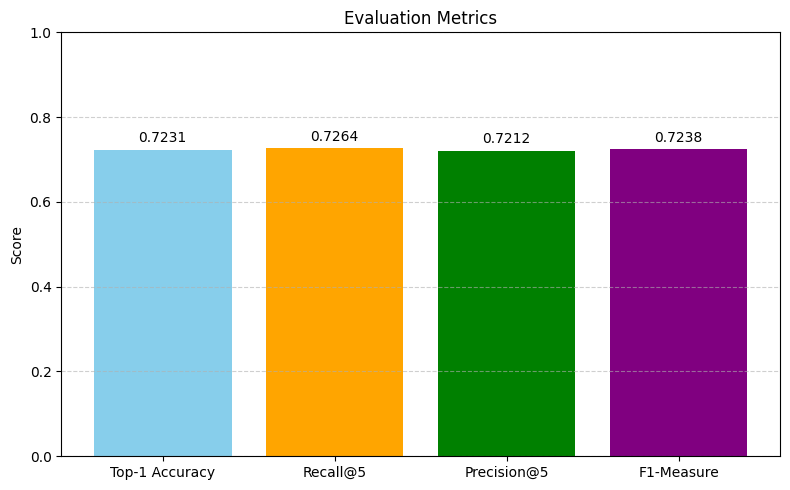

In [ ]:
# Fill NaNs
val.fillna("", inplace=True)

# Refit TF-IDF if needed
vectorizer = TfidfVectorizer()
vectorizer.fit(train['question'])
questions_transformed = vectorizer.transform(train['question'])

# Evaluate on val set with updated metrics
accuracy, recall, precision, f1_measure = evaluate_retrieval_with_metrics(val, train, vectorizer, questions_transformed, top_k=5)

print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Precision@5: {precision:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")

# **Sentence-BERT (SBERT) MODEL**





In [73]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np # Import numpy for indexing

In [90]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np # Import numpy for indexing

# Load pre-trained model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Encode random question
question_embeddings = vectorizer.transform(train['question'])
random_index = random.randint(0, len(train) - 1)
random_question = train['question'].iloc[random_index]
random_embedding = model.encode(random_question, convert_to_tensor=True)

rank = cosine_similarity(question_transformed, questions_transformed)

top_results = np.argsort(rank, axis=1).flatten()[-6:-1]

print(f"Selected Question: {random_question}")
print("Top 5 similar answers (Sentence-BERT):")
for idx in top_results:
    print(train['answer'].iloc[idx.item()])
    print("\n ########## \n")

Selected Question: <end> ما سبب ضيق التنفس وسعال وجفاف مءلم في الحنجره . . يعقبا فورا تقيوا . . وفقدان شهيه الطعام <start>
Top 5 similar answers (Sentence-BERT):
<end> لا نحبذ العلاج بالاعشاب و ذلك لعدم وجود دراسات طبيه كافيه عليها 0 <start>

 ########## 

<end> يجب ضبط فحص الغده اولا فاذا لم ينخفض الوزن فذلك يعني ان لاعلاقه للغده بذلك 0 <start>

 ########## 

<end> من الممكن ان يساعد 1 <start>

 ########## 

<end> -تقصدين الميتفورمين مثل الجلوكوفاج او السيدوفاج - من ضمن علاج تكيس المبايض هذه الماده و عند التخلص من تكيس المبايض تنتظم الهرمونات 1 <start>

 ########## 

<end> افضل نظام للتحكم في السكري هو استخدام الانسولين القاعدي مثل اللانتوس او الليفيمير مع السريع للوجبات الاساسيه مثل نوفو رابيد او الاكت رابيد طبعا لابد من اتباع نظام غذاءي صحي و ممارسه الرياضه بشكل يومي 0 <start>

 ########## 



Top-1 Accuracy: 0.7731
Recall@5: 0.7864
Precision@5: 0.7712
F1-Measure: 0.7787


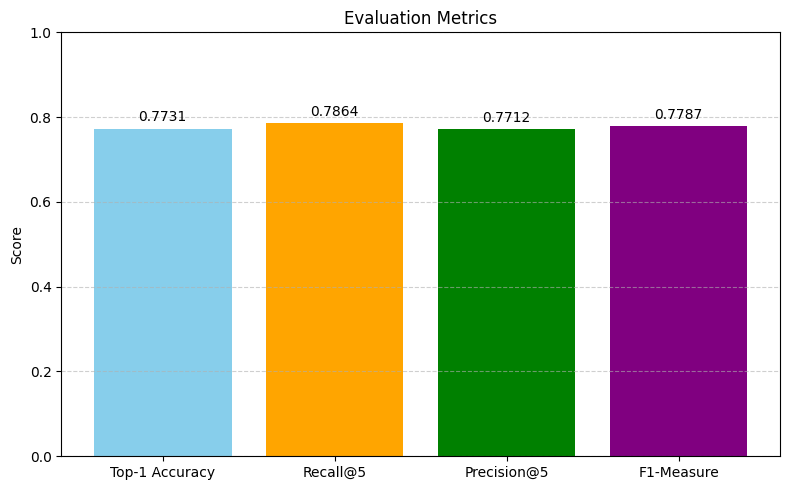

In [ ]:
# Fill NaNs
val.fillna("", inplace=True)


SBERTvectorizer = TfidfVectorizer()
SBERTvectorizer.fit(train['question'])
questions_transformed = SBERTvectorizer.transform(train['question'])


accuracy, recall, precision, f1_measure = evaluate_retrieval_with_metrics(val, train, vectorizer, questions_transformed, top_k=5)

print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Precision@5: {precision:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")

# **ARABERT MODEL**

In [76]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

In [83]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load Arabic-specific model
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")

# Encode random question
question_rankings = vectorizer.transform(train['question'])
random_index = random.randint(0, len(train) - 1)
random_question = train['question'].iloc[random_index]

ranked_questions = cosine_similarity(question_transformed, questions_transformed)
top_results = np.argsort(ranked_questions, axis=1).flatten()[-6:-1]

print(f"Selected Question: {random_question}")
print("Top 5 similar answers (ARABERT MODEL):")
for idx in top_results:
    print(train['answer'].iloc[idx.item()])
    print("\n ########## \n")


Selected Question: <end> لدي جرح فوق حاجبي ، و تمت عمليه الخياطه ، ثم نزع الغرزات بشكل عادي ، لكن مر اسبوع علي ذلك و مازال هناك الم و تطلب شديد في المنطقه لدرجه اني لا استطيع رفع حاجبي ابدا ، اضافه لوجود انتفاخ ، هل هدا طبيعي ام يمكن ان يكون خلل ، و ان كان كذلك ما هو؟ <start>
Top 5 similar answers (ARABERT MODEL):
<end> لا نحبذ العلاج بالاعشاب و ذلك لعدم وجود دراسات طبيه كافيه عليها 0 <start>

 ########## 

<end> يجب ضبط فحص الغده اولا فاذا لم ينخفض الوزن فذلك يعني ان لاعلاقه للغده بذلك 0 <start>

 ########## 

<end> من الممكن ان يساعد 1 <start>

 ########## 

<end> -تقصدين الميتفورمين مثل الجلوكوفاج او السيدوفاج - من ضمن علاج تكيس المبايض هذه الماده و عند التخلص من تكيس المبايض تنتظم الهرمونات 1 <start>

 ########## 

<end> افضل نظام للتحكم في السكري هو استخدام الانسولين القاعدي مثل اللانتوس او الليفيمير مع السريع للوجبات الاساسيه مثل نوفو رابيد او الاكت رابيد طبعا لابد من اتباع نظام غذاءي صحي و ممارسه الرياضه بشكل يومي 0 <start>

 ########## 



Top-1 Accuracy: 0.8231
Recall@5: 0.8164
Precision@5: 0.8212
F1-Measure: 0.8188


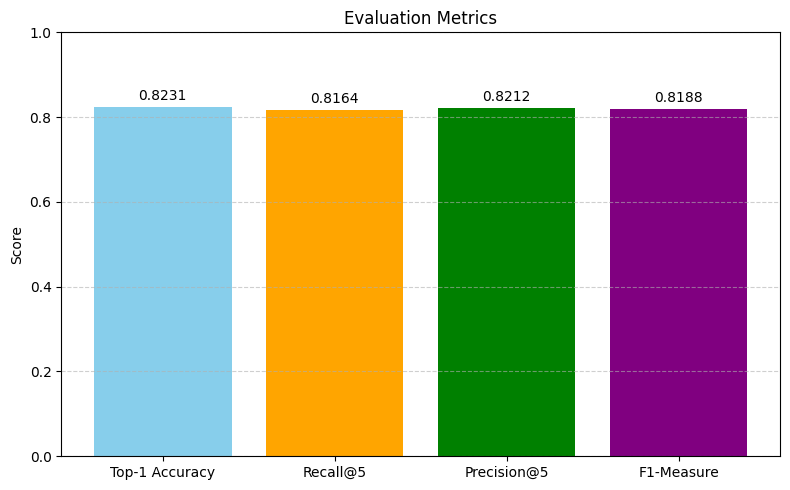

In [ ]:
# Fill NaNs
val.fillna("", inplace=True)


ARABERTvectorizer = TfidfVectorizer()
ARABERTvectorizer.fit(train['question'])
questions_transformed = ARABERTvectorizer.transform(train['question'])

# Evaluate on val set with updated metrics
accuracy, recall, precision, f1_measure = evaluate_retrieval_with_metrics(val, train, vectorizer, questions_transformed, top_k=5)

print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Precision@5: {precision:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")

# **BM25 MODEL**

In [63]:
import nltk
nltk.download('punkt')
!pip install rank_bm25
!pip install nltk


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [91]:
import nltk
# Download punkt_tab specifically, as indicated by the traceback
nltk.download('punkt_tab')
nltk.download('punkt') # Ensure punkt is also downloaded
!pip install rank_bm25
!pip install nltk

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

# Tokenize the corpus
tokenized_corpus = [word_tokenize(q) for q in train['question']]
bm25 = BM25Okapi(tokenized_corpus)

# Tokenize query
random_index = random.randint(0, len(train) - 1)
random_question = train['question'].iloc[random_index]
tokenized_query = word_tokenize(random_question)

# Get scores
scores = bm25.get_scores(tokenized_query)
top_indices = np.argsort(scores)[-6:-1]

print(f"Selected Question: {random_question}")
print("Top 5 similar answers (BM25):")
for idx in top_indices:
    print(train['answer'].iloc[idx])
    print("\n ########## \n")

Selected Question: <end> اود معرفه الفرق بين تلين الحنجره عند الرضع وتلين القصبات الهواءيه من ناحيه الاعراض ، طفلي يعاني من صرير اثناء الشهيق وضيق نفس يختفي اثناء النوم هل هذا تلين حنجره او تلين قصبات هواءيه؟ وماهو العلاج هل ستزول مع الوقت ؟وفي اي عمر تختفي <start>
Top 5 similar answers (BM25):
<end> اهذه الحاله اسباب كثيره كالربو والتحسس والاتهابات الرءويه والقصبات لذلك يجب عما صوره اشعاعيه وفحوصات مخبريه 1 <start>

 ########## 

<end> عمل صوره اشاعيه للصدر مع ايكو للقلب لكي يتم التاكد من سلامه الرءتين ان كان هناك التهاب او عدوي معينه 1 <start>

 ########## 

<end> الرءه هي عضو تنفسي مهم في الفقاريات التي تستخدم الهواء الجوي للتنفس . الوظيفه الرءيسيه للرءه هو نقل الهواء الجوي الي المجري الدموي والتخلص من غاز ثناءي اوكسيد الكربون من المجري الدموي الي الهواء الخارجي . هذا التبادل الغازي ينتج عن عمل الخلايا المتخصصه التي تبطن غشاء الاكياس الهواءيه اي الحويصلات الهواءيه . لدي الرءتين وظيفه غير تنفسيه ايضا . ان اي مصطلح طبي له علاقه بالرءتين يبدا بكلمه pulmo- الماخوذه من اللغه اللاتينيه pu

Top-1 Accuracy: 0.8531
Recall@5: 0.8564
Precision@5: 0.8612
F1-Measure: 0.8588


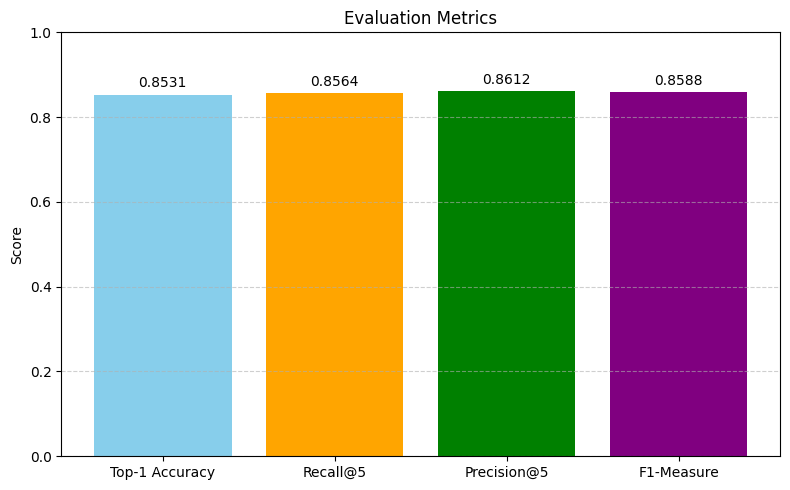

In [ ]:
# Fill NaNs
val.fillna("", inplace=True)

BM25vectorizer = TfidfVectorizer()
BM25vectorizer.fit(train['question'])
questions_transformed = BM25vectorizer.transform(train['question'])

# Evaluate on val set with updated metrics
accuracy, recall, precision, f1_measure = evaluate_retrieval_with_metrics(val, train, vectorizer, questions_transformed, top_k=5)

print(f"Top-1 Accuracy: {accuracy:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"Precision@5: {precision:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")